#### Example of text classification Keras' Convolutional Neural Network

Reference pages:
- https://realpython.com/python-keras-text-classification/#convolutional-neural-networks-cnn
- https://machinelearningmastery.com/how-to-calculate-precision-recall-f1-and-more-for-deep-learning-models/

The dataset was preprocessed in **finance complaints dataset analysis** notebook.

Loading balanced dataset.

In [1]:
import pandas as pd
df = pd.read_csv('complaints-balanced.csv')
print(df.isnull().sum())
df.head()

Unnamed: 0                      0
Product                         0
Consumer_complaint_narrative    0
category_id                     0
dtype: int64


,Unnamed: 0,Product,Consumer_complaint_narrative,category_id
0,0,"Credit reporting, credit repair services, or o...",These aren't mine ... please remove it.,0
1,1,"Credit reporting, credit repair services, or o...",XXXX and Transunion are incorrectly reporting ...,0
2,2,"Credit reporting, credit repair services, or o...",I have been disputing a derogatory mark on my ...,0
3,3,"Credit reporting, credit repair services, or o...",I have sent 3 letters to all 3 credit bureau '...,0
4,4,"Credit reporting, credit repair services, or o...",ive been working back and forth calling emaili...,0


Text preprocessing

In [2]:
%%time
import re

text = df.Consumer_complaint_narrative
# removing numbers
text = text.apply(lambda x: re.sub(r'\d+', '', x))

# removing XXX words
text = text.apply(lambda x: re.sub(r'X*', '', x))

# converting to lower case
text = text.apply(lambda x: x.lower())

text.head()

CPU times: user 1.34 s, sys: 10.5 ms, total: 1.35 s
Wall time: 1.35 s


0              these aren't mine ... please remove it.
1     and transunion are incorrectly reporting me a...
2    i have been disputing a derogatory mark on my ...
3    i have sent  letters to all  credit bureau 's,...
4    ive been working back and forth calling emaili...
Name: Consumer_complaint_narrative, dtype: object

Creating train and test sets, with balanced frequency of classes.

In [3]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

# encoding labels to one hot vectors
encoder = LabelEncoder()
encoder.fit(df['category_id'])
encoded_Y = encoder.transform(df['category_id'])
Y = np_utils.to_categorical(encoded_Y)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3)
for train_index, test_index in sss.split(text, Y):
    train_sentences = text.loc[train_index]
    Y_train = Y[train_index]
    test_sentences = text.loc[test_index]
    test_labels = df['category_id'].loc[test_index]
    Y_test = Y[test_index]

Using TensorFlow backend.


**Preparing the input**

The `Tokenizer` utility class which can vectorize a text corpus into a list of integers. Each integer maps to a value in a dictionary that encodes the entire corpus, with the keys in the dictionary being the vocabulary terms themselves. We can add the parameter `num_words`, which is responsible for setting the size of the vocabulary. The most common `num_words` words will be then kept.

In [4]:
%%time
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_sentences)

X_train = tokenizer.texts_to_sequences(train_sentences)
X_test = tokenizer.texts_to_sequences(test_sentences)

# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

CPU times: user 906 ms, sys: 7.54 ms, total: 914 ms
Wall time: 913 ms


The indexing is ordered after the most common words in the text. It is important to note that the index 0 is reserved and is not assigned to any word. This zero index is used for padding, which will be done in a moment.

Unknown words (words that are not in the vocabulary) are denoted in Keras with word_count + 1 since they can also hold some information. You can see the index of each word by taking a look at the `word_index` dictionary of the `Tokenizer` object.

In [5]:
for word in ['the', 'all', 'happy', 'sad']:
    print('{}: {}'.format(word, tokenizer.word_index[word]))

the: 1
all: 49
happy: 1524
sad: 3134


With Tokenizer, the resulting vectors equal the length of each text, and the resulting vectors won't have the same length. To counter this, you can use `pad_sequence()` which simply pads the sequence of words with zeros. By default, it prepends zeros but we will to append them. Additionally you would want to add a `maxlen` parameter to specify how long the sequences should be. This cuts sequences that exceed that number.

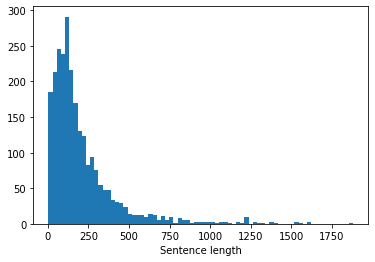

In [7]:
import matplotlib.pyplot as plt

# analyzing the sentences' length
freqs = pd.Series(X_train).apply(lambda x: len(x))
plt.hist(freqs, bins='auto') 
plt.xlabel('Sentence length');

In [8]:
from keras.preprocessing.sequence import pad_sequences

max_len = 450

X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
X_test = pad_sequences(X_test, padding='post', maxlen=max_len)

**Creating and traning the model**

We can use the Embedding Layer of Keras which takes the previously calculated integers and maps them to a dense vector of the embedding. We will use the following parameters:

- `input_dim`: the size of the vocabulary
- `output_dim`: the size of the dense vector
- `input_length`: the length of the sequence

The embedding layer is followed by a convolutional layer.

- `filters`: the number of filters/neurons/kernel in the layer. Thus, this also sets the output dimension.
- `kernel_size`: the lentgh of the convolution window. In our case, how many tokens will be processed by each filter.
- `activation`: the activation function.

After the convolutional layer, we will apply a pooling layer (`GlobalMaxPooling1D` or `GlobalAveragePooling1D`).

In [9]:
from keras.models import Sequential
from keras import layers

embedding_dim = 150

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=max_len))
model.add(layers.Conv1D(filters=128, 
                        kernel_size=5, 
                        activation='relu'))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, 
                       activation='relu'))
model.add(layers.Dense(5, 
                       activation='sigmoid'))
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 450, 150)          1559250   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 446, 128)          96128     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 55        
Total params: 1,656,723
Trainable params: 1,656,723
Non-trainable params: 0
_________________________________________________________________


Training the model.

In [10]:
%%time
history = model.fit(X_train, 
                    Y_train,
                    epochs=10,
                    verbose=False,
                    validation_data=(X_test, Y_test),
                    batch_size=10)

/home/alexandre/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


CPU times: user 11min 50s, sys: 5min 10s, total: 17min 1s
Wall time: 4min 25s


Evaluation.

Training Accuracy: 0.9881
Testing Accuracy:  0.8211


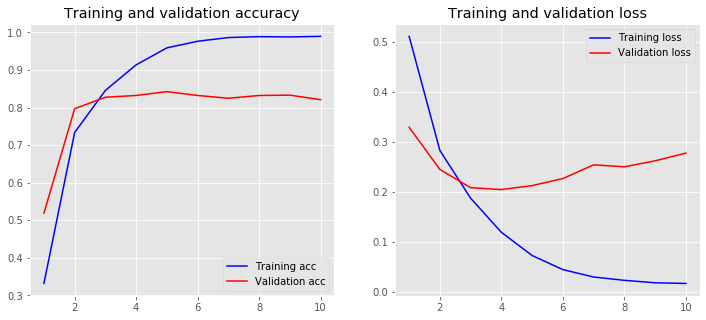

In [11]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

loss, accuracy = model.evaluate(X_train, 
                                Y_train, 
                                verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model.evaluate(X_test, 
                                Y_test, 
                                verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

plot_history(history)

In [12]:
from sklearn.metrics import accuracy_score, confusion_matrix

my_tags = df.category_id.unique()
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(my_tags))
    target_names = my_tags
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def evaluate_prediction(predictions, target, title="Confusion matrix"):
    print('accuracy %s' % accuracy_score(target, predictions))
    cm = confusion_matrix(target, predictions, labels=my_tags)
    print('confusion matrix\n %s' % cm)
    print('(row=expected, col=predicted)')
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(cm_normalized, title + ' Normalized')

accuracy 0.8211306765523633
confusion matrix
 [[182  22   8   4   0]
 [ 38 161   7   8   1]
 [ 20  12 171   5   8]
 [  7   6   1 193   9]
 [ 10   0  20   7 179]]
(row=expected, col=predicted)
              precision    recall  f1-score   support

           0       0.71      0.84      0.77       216
           1       0.80      0.75      0.77       215
           2       0.83      0.79      0.81       216
           3       0.89      0.89      0.89       216
           4       0.91      0.83      0.87       216

    accuracy                           0.82      1079
   macro avg       0.83      0.82      0.82      1079
weighted avg       0.83      0.82      0.82      1079



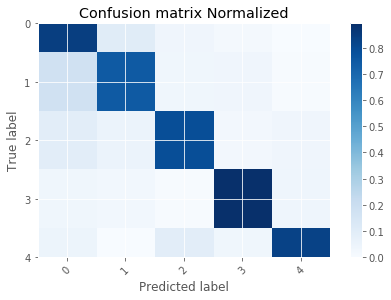

In [13]:
import numpy as np
from sklearn import metrics

Y_pred = model.predict(X_test, 
                       verbose=0)
evaluate_prediction(Y_pred.argmax(axis=1), 
                    Y_test.argmax(axis=1))

print(metrics.classification_report(Y_test.argmax(axis=1), 
                                    Y_pred.argmax(axis=1)))